Iteration  0
z_h shape:  (10000, 1000)
x_h shape:  (10000, 1000)
z_o shape:  (10000, 10)
x_o shape:  (10000, 10)
Accuracy  0.0908
Loss  2.408047452725836
Shape dL  (10000, 10)
Shape dW_o  (1000, 10)
Shape of db_o:  (1, 10)
Shape of db_h:  (10000, 1000)
Shape dW_h  (784, 1000)
Shape of db_h:  (1, 1000)
z_h shape:  (6000, 1000)
x_h shape:  (6000, 1000)
z_o shape:  (6000, 10)
x_o shape:  (6000, 10)
Shape dL  (6000, 10)
Shape dW_o  (1000, 10)
Shape of db_o:  (1, 10)
Shape of db_h:  (6000, 1000)
Shape dW_h  (784, 1000)
Shape of db_h:  (1, 1000)
Iteration  1
z_h shape:  (10000, 1000)
x_h shape:  (10000, 1000)
z_o shape:  (10000, 10)
x_o shape:  (10000, 10)
Accuracy  0.3071
Loss  2.0344716503574256
Shape dL  (10000, 10)
Shape dW_o  (1000, 10)
Shape of db_o:  (1, 10)
Shape of db_h:  (10000, 1000)
Shape dW_h  (784, 1000)
Shape of db_h:  (1, 1000)
z_h shape:  (6000, 1000)
x_h shape:  (6000, 1000)
z_o shape:  (6000, 10)
x_o shape:  (6000, 10)
Shape dL  (6000, 10)
Shape dW_o  (1000, 10)
Shape of d

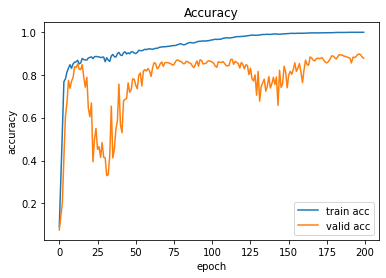

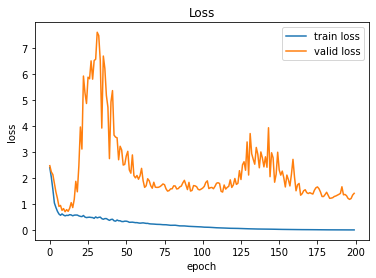

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Load the data
def load_data():
    with np.load("notMNIST.npz") as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target


def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test



def shuffle(data, target):
    np.random.seed(421)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]


# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def relu(x):
    # TODO
    # x is an array so we need to check element wise if x[i] > 0 or not
    return np.maximum(x, 0)

def softmax(x):
    # TODO
    # prevent overflow
    x = x - (np.max(x, axis=1)).reshape(x.shape[0], 1)
    # x = x - x.max(axis=1, keepdims=True)
    #return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    return np.exp(x) / (np.sum(np.exp(x), axis=1)).reshape(x.shape[0],1)


def compute_layer(x, w, b):
    # TODO
    # return x@w + b
    # x: N, F
    # w: F, H
    # b: 1, H
    # return N, H
    #s = np.dot(x, w) + np.transpose(b)
    s = np.matmul(x, w) + b
    return s

def average_ce(target, prediction):
    # TODO
    N = target.shape[0]
    #avg_ce = -np.sum(np.multiply(target, np.log(prediction))) / N
    avg_ce = -np.sum(target * np.log(prediction + 0.00001)) / N
    return avg_ce


def grad_ce(target, logits):
    # TODO
    #prediction = softmax(logits)
    # return (prediction-target).mean(axis=0)
    return (logits - target)


def forward_prop(x, b_h, W_h, b_o, W_o):
  # compute output
  ''' x: N, 784 input vector
      W_o, W_h: K, 10 and 784, K weights at hidden and output layer
      b_h, b_o: 1, K and 1, 10 biases at hidden and output layer
  '''
  #print("Point A")
  #x = np.expand_dims(x, axis=1)

  z_h = compute_layer(x, W_h, b_h)
  print("z_h shape: ", z_h.shape)
  x_h = relu(z_h)
  print("x_h shape: ", x_h.shape)

  z_o = compute_layer(x_h, W_o, b_o)
  print("z_o shape: ", z_o.shape)
  x_o = softmax(z_o)
  print("x_o shape: ", x_o.shape)
  #x_o = np.squeeze(x_o, axis = 1)
  #print("Point B")
  return x_h, x_o, z_o, z_h



def back_prop(x_h, x_o, x, W_o, z_o, target, z_h):
  N = len(x)
  #print("Point D")
  # compute gradients
  #dL = grad_ce(target, x_o)
  dL = grad_ce(target, x_o)
  print("Shape dL ", dL.shape)
  # from video
  #dW_o = x_h@np.transpose(dL) #x_h*(p-y)
  #dW_o = np.dot(x_h, dL)
  dW_o = np.dot(np.transpose(x_h), dL) * (1/N)
  db_o = np.transpose(sum(dL).reshape(10, 1)) * (1/N) # not sure
  #db_o = np.mean(dL, axis=0, keepdims=True)
  #db_o = np.dot(1, dL) * (1/N)
  print("Shape dW_o ", dW_o.shape)
  print("Shape of db_o: ", db_o.shape)

  #dW_h = np.dot(np.transpose(x), np.where(x_h > 0, 1, 0) * np.dot(dL, np.transpose(w_o))) * (1/N)
  #db_h = sum(np.where(x_h > 0,1,0) * np.dot(dL, np.transpose(w_o))).reshape(10000, 1) * (1/N)
  dxi = np.dot(dL, np.transpose(w_o))
  dxi = np.where(z_h > 0, dxi, 0)
  dW_h = np.dot(np.transpose(x), dxi) * (1/N)
  #db_h = np.mean(1, dxi)
  db_h = np.dot(1, dxi) * (1/N)
  dummy = np.ones((1, N))
  print("Shape of db_h: ", db_h.shape)
  db_h = np.matmul(dummy, db_h)


  print("Shape dW_h ", dW_h.shape)
  print("Shape of db_h: ", db_h.shape)

  #print("Point E")
  return dW_o, db_o, dW_h, db_h


def xavier(inside, out):
  return np.random.normal(0, math.sqrt(2/(inside+out)), (inside,out))



train_data, valid_data, test_data, train_target, valid_target, test_target = load_data()

train_target, valid_target, test_target = convert_onehot(train_target, valid_target, test_target)

train_data = train_data.reshape(len(train_data), -1)
valid_data = valid_data.reshape(len(valid_data), -1)
test_data = test_data.reshape(len(test_data), -1)
x_i = train_data
x_i = x_i.reshape(10000, 784)

x_i_valid = valid_data
#x_ivalid = x_ivalid.reshape(6000, 784)


k = 10000
h = 1000
w_h = xavier(784, h)
#b_h = np.zeros((1,k))
b_h = np.zeros((1,h))
#b_h = np.zeros((k,1))
w_o = xavier(h, 10)
b_o = np.zeros((1,10))
#b_o = np.zeros((10,1))


w_h_valid = xavier(784, h)
#b_h = np.zeros((1,k))
b_h_valid = np.zeros((1,h))
#b_h = np.zeros((k,1))
w_o_valid = xavier(h, 10)
b_o_valid = np.zeros((1,10))
#b_o = np.zeros((10,1))

vw_h = np.full((784,h), 10e-5)
vb_h = np.full((1,h), 10e-5)
#vb_h = np.full((k,1), 10e-5)
vw_o = np.full((h,10), 10e-5)
vb_o = np.full((1,10), 10e-5)
#vb_o = np.full((10,1), 10e-5)

vw_h_valid = np.full((784,h), 10e-5)
vb_h_valid = np.full((1,h), 10e-5)
#vb_h = np.full((k,1), 10e-5)
vw_o_valid = np.full((h,10), 10e-5)
vb_o_valid = np.full((1,10), 10e-5)
#vb_o = np.full((10,1), 10e-5)

gamma = 0.99
learning_rate = 0.1
accuracies = []
losses = []
accuracies_valid = []
losses_valid = []

for epoch in range(200):
  #if epoch % 10 == 0:
    #print("Iteration ", epoch)
  print("Iteration ", epoch)
  # forward step
  x_h, x_o, z_o, z_h = forward_prop(x_i, b_h, w_h, b_o, w_o)
  prediction = np.argmax(x_o, axis = 1)
  target = np.argmax(train_target, axis=1)


  # find accuracy
  accuracy = (prediction == target).mean()
  accuracies.append(accuracy)

  # find loss
  loss = average_ce(train_target, x_o)
  losses.append(loss)


  print("Accuracy ", accuracy)
  print("Loss ", loss)

  #print("Point C")
  # backward step
  d_wo, d_bo, d_wh, d_bh = back_prop(x_h, x_o, x_i, w_o, z_o, train_target, z_h)

  vw_h = gamma*vw_h + learning_rate*d_wh
  vb_h = gamma*vb_h + learning_rate*d_bh
  vw_o = gamma*vw_o + learning_rate*d_wo
  vb_o = gamma*vb_o + learning_rate*d_bo

  w_h = w_h - vw_h
  b_h = b_h - vb_h
  w_o = w_o - vw_o
  b_o = b_o - vb_o

  # validation
  x_h_valid, x_o_valid, z_o_valid, z_h_valid = forward_prop(x_i_valid, b_h_valid, w_h_valid, b_o_valid, w_o_valid)
  prediction_valid = np.argmax(x_o_valid, axis = 1)
  target_valid = np.argmax(valid_target, axis=1)

  # find accuracy
  accuracy_valid = (prediction_valid == target_valid).mean()
  accuracies_valid.append(accuracy_valid)

  # find loss
  loss_valid = average_ce(valid_target, x_o_valid)
  losses_valid.append(loss_valid)

  d_wo_valid, d_bo_valid, d_wh_valid, d_bh_valid = back_prop(x_h_valid, x_o_valid, x_i_valid, w_o_valid, z_o_valid, valid_target, z_h_valid)

  vw_h_valid = gamma*vw_h_valid + learning_rate*d_wh_valid
  vb_h_valid = gamma*vb_h_valid + learning_rate*d_bh_valid
  vw_o_valid = gamma*vw_o_valid + learning_rate*d_wo_valid
  vb_o_valid = gamma*vb_o_valid + learning_rate*d_bo_valid

  w_h_valid = w_h_valid - vw_h_valid
  b_h_valid = b_h_valid - vb_h_valid
  w_o_valid = w_o_valid - vw_o_valid
  b_o_valid = b_o_valid - vb_o_valid

#plt.title("Training Accuracy")
plt.title("Accuracy")
plt.plot(accuracies)
plt.plot(accuracies_valid)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train acc", "valid acc"])
plt.show()

#plt.title("Training loss")
plt.title("Loss")
plt.plot(losses)
plt.plot(losses_valid)
plt.ylabel("loss")
plt.legend(["train loss", "valid loss"])
plt.xlabel("epoch")
plt.show()